In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## The dataset

#### This is a subsample of the PISA 2022 dataset focusing on UK only including England, Scotland, Wales and Northern Ireland. We are looking at all students in the UK and we aim to identify whether a study is academically 'at-risk' or 'not-at-risk'

'at-risk' students are students who are underperforming in all three subjects (maths, english & science)

In [4]:
df = pd.read_csv('/workspaces/mini_project_2/data/uk_pisa_risk_model.csv')

In [5]:
df.head()

,PV1MATH,PV1READ,PV1SCIE,ESCS,avg_score,Gender_Label_Male,Immigrant_Status_Native,Immigrant_Status_Second-Generation Immigrant,Region_Name_Northern Ireland,Region_Name_Scotland,Region_Name_Wales,SES_Group_Numeric,At_Risk
0,699.809,650.831,660.872,-0.2845,670.504000,False,True,False,False,False,True,1,0
1,454.479,482.339,461.361,-0.6117,466.059667,False,True,False,True,False,False,0,1
2,566.143,519.729,619.621,1.2878,568.497667,False,True,False,False,False,False,3,0
3,371.820,319.932,286.866,-0.5213,326.206000,True,True,False,False,False,False,1,1
4,423.607,350.200,386.375,0.6203,386.727333,False,False,False,False,False,False,2,1


In [31]:
# Features for At-Risk model (all students)
features = ['Gender_Label_Male', 'Immigrant_Status_Native', 
           'Immigrant_Status_Second-Generation Immigrant', 
           'SES_Group_Numeric']

In [45]:
df["At_Risk"].value_counts()

At_Risk
0    6876
1    3809
Name: count, dtype: int64

In [32]:
# Prepare data
X = df[features]
y = df['At_Risk']

In [33]:
print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Class balance: {y.value_counts(normalize=True)}")

Dataset shape: (10685, 4)
Target distribution:
At_Risk
0    6876
1    3809
Name: count, dtype: int64
Class balance: At_Risk
0    0.643519
1    0.356481
Name: proportion, dtype: float64


In [34]:
# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 80% train, 20% test
    random_state=42,         # For reproducibility
    stratify=y               # Maintain class distribution in both sets
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")


Train set shape: (8548, 4)
Test set shape: (2137, 4)
Train target distribution:
At_Risk
0    0.643542
1    0.356458
Name: proportion, dtype: float64
Test target distribution:
At_Risk
0    0.643425
1    0.356575
Name: proportion, dtype: float64


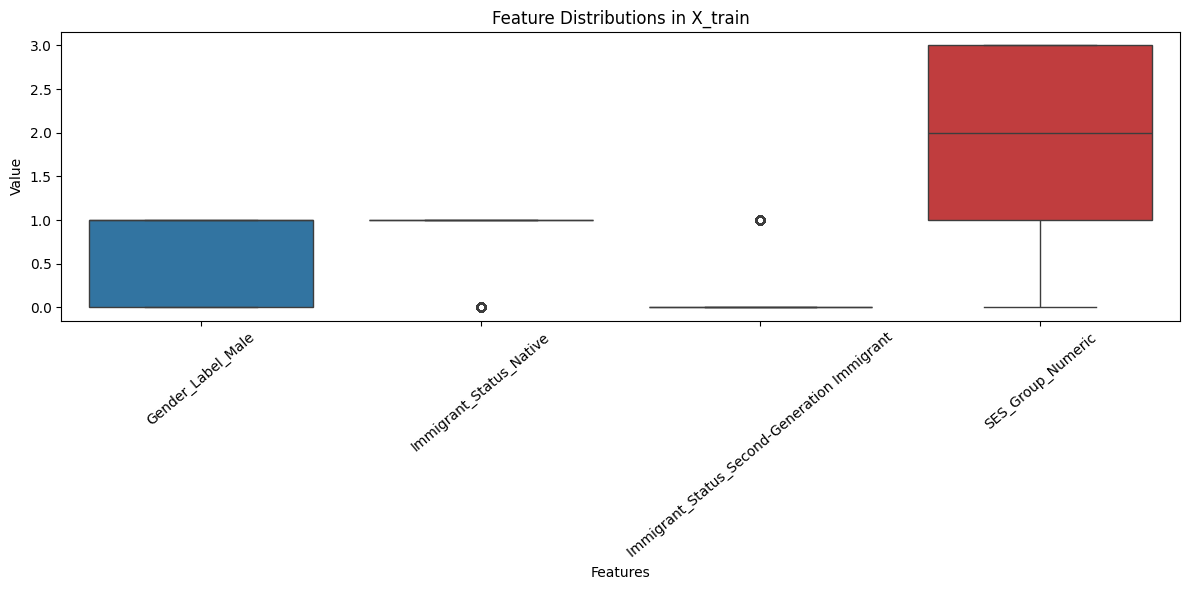

In [35]:
# Your code here...
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train)
plt.xticks(rotation=400)
plt.xlabel('Features')
plt.ylabel('Value')
plt.title('Feature Distributions in X_train')
plt.tight_layout()
plt.show()

### Train a decision tree

In [36]:
dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
print(dtc)


DecisionTreeClassifier()


### fit the model on the training set 

In [37]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [38]:
dtc.get_depth()
dtc.get_n_leaves()

6

In [39]:
dtc.get_n_leaves()

np.int64(24)

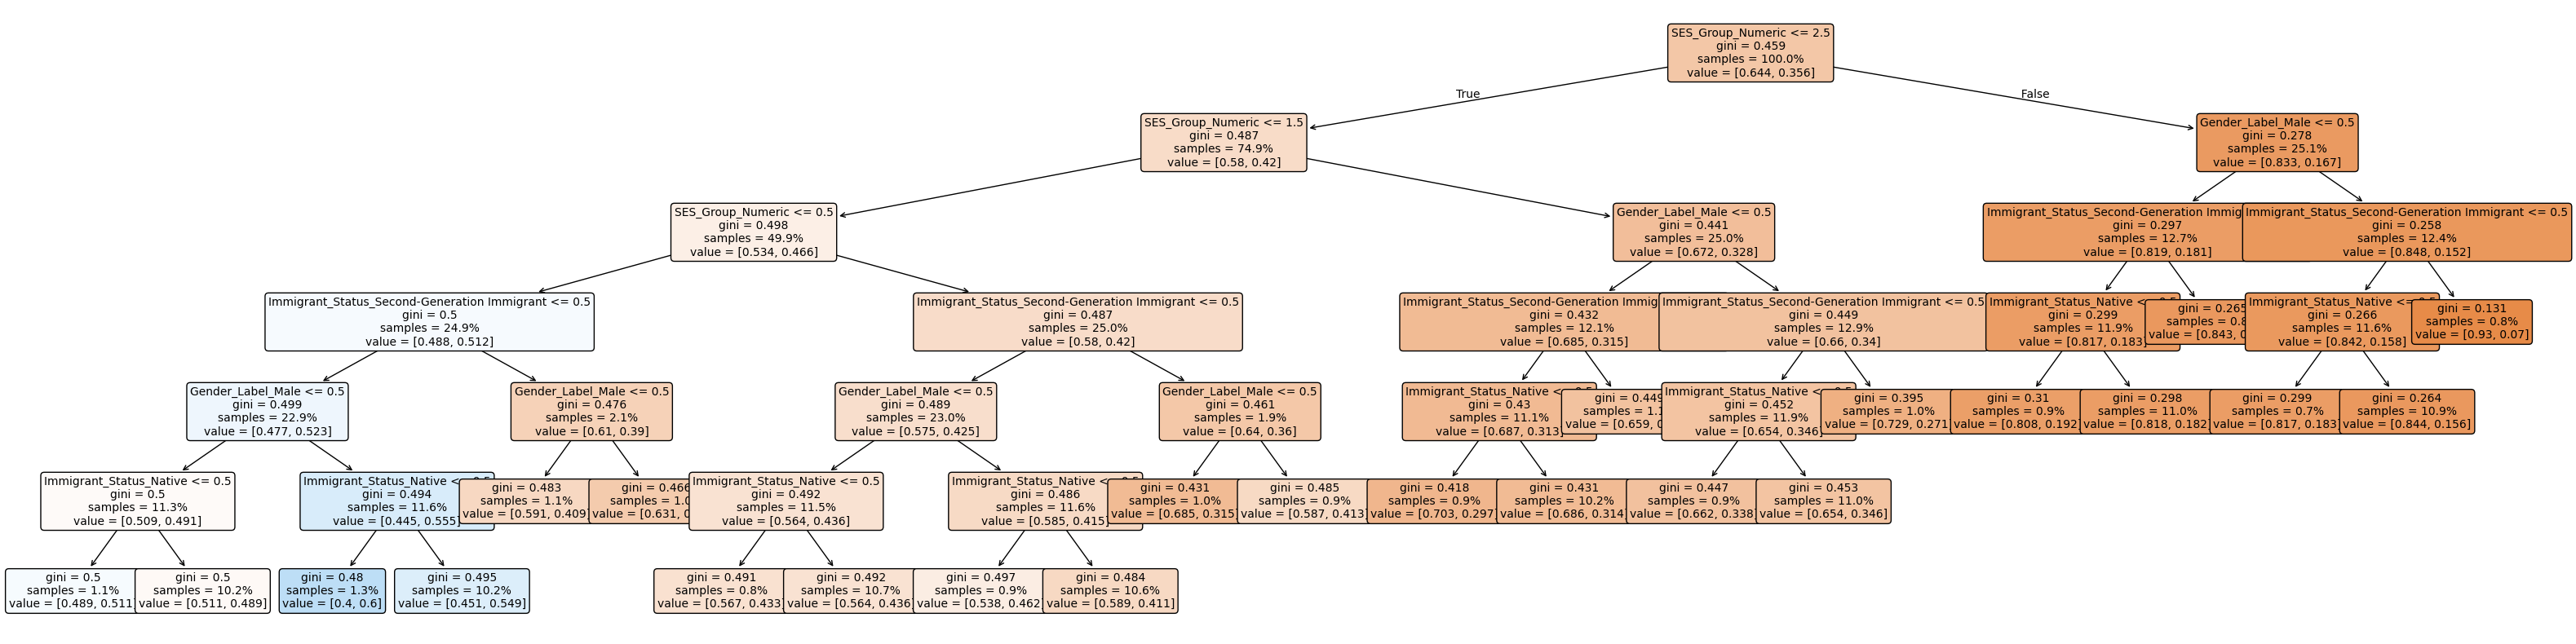

In [40]:
plt.figure(figsize=(40, 10))
plot_tree(dtc, 
          filled=True, 
          rounded=True,
          max_depth=41,
          proportion=True,
          fontsize=10,
          feature_names=list(X_train.columns))
plt.show()

### inspect the accuracy of the model 

In [41]:
#inspect the accuracy of the model 
print(accuracy_score(y_train, dtc.predict(X_train)))
print(accuracy_score(y_test, dtc.predict(X_test)))

print(classification_report(y_test, dtc.predict(X_test)))

0.6564108563406644
0.6607393542349087


In [42]:
# generate the classification report 

print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78      1375
           1       0.56      0.21      0.31       762

    accuracy                           0.66      2137
   macro avg       0.62      0.56      0.54      2137
weighted avg       0.64      0.66      0.61      2137



### Exploration of different hyperparameters 

In [66]:
# train a regularised tree (max depth is now 3)
dtc_reg = DecisionTreeClassifier(max_depth=5, min_samples_split=100)
dtc_reg.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=100)

In [67]:
print(accuracy_score(y_train, dtc_reg.predict(X_train)))
print(accuracy_score(y_test, dtc_reg.predict(X_test)))

0.6561768834815161
0.660271408516612


In [68]:
print(classification_report(y_test, dtc_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.92      0.78      1375
           1       0.57      0.19      0.29       762

    accuracy                           0.66      2137
   macro avg       0.62      0.56      0.53      2137
weighted avg       0.64      0.66      0.60      2137



# Changing the depth of the tree doesn't seem to make any difference which may suggest that the issue is linked to class imbalances instead

In [69]:
#set the hyperparamter class_weight to balanced and retrain the tree 
dtc_reg.set_params(class_weight="balanced")
dtc_reg.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=100)

In [70]:
print(classification_report(y_test, dtc_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1375
           1       0.46      0.65      0.54       762

    accuracy                           0.61      2137
   macro avg       0.61      0.62      0.60      2137
weighted avg       0.65      0.61      0.62      2137



# Feature Importance

In [71]:
 dtc_reg.feature_importances_

array([2.07376505e-02, 6.21890071e-04, 2.85637330e-02, 9.50076726e-01])

In [72]:

importances_df = pd.DataFrame(
    dtc_reg.feature_importances_,
    columns=["importance"],
    index=X_train.columns
)
importances_df.sort_values("importance", ascending=False).head()

,importance
SES_Group_Numeric,0.950077
Immigrant_Status_Second-Generation Immigrant,0.028564
Gender_Label_Male,0.020738
Immigrant_Status_Native,0.000622


so this tells us that almost the entire decision tre is splitting on SES, gender and immigrant status have a very little role - the model is almost entirly dependent on SES 

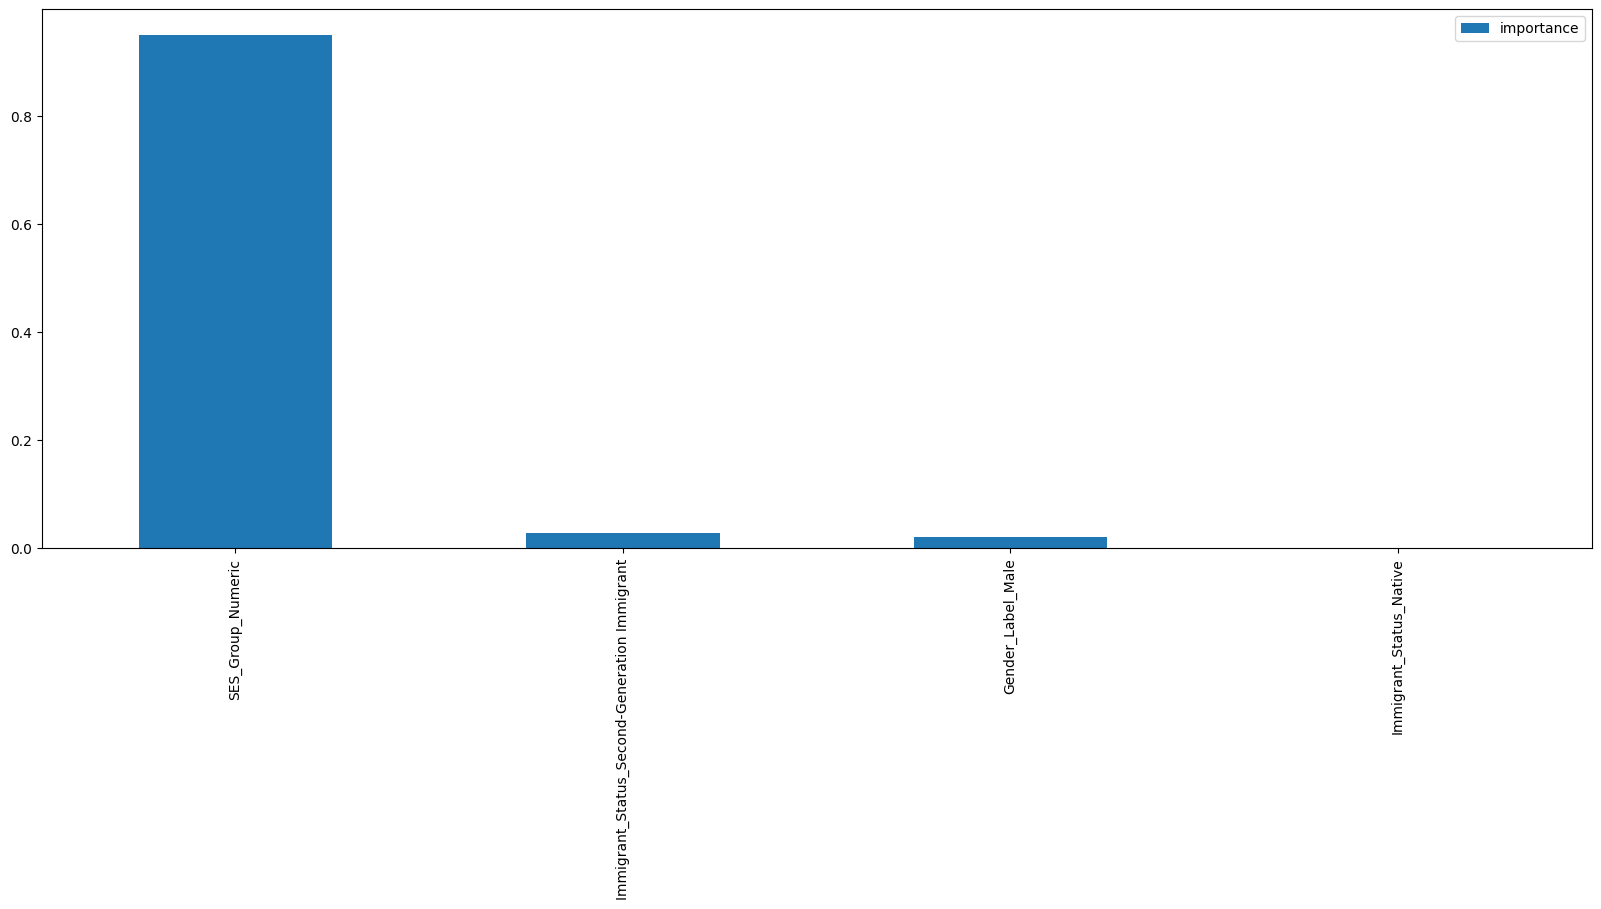

In [73]:
importances_df.sort_values("importance", ascending=False).plot(kind="bar", figsize=(20,7))
plt.show()

# Inference time 

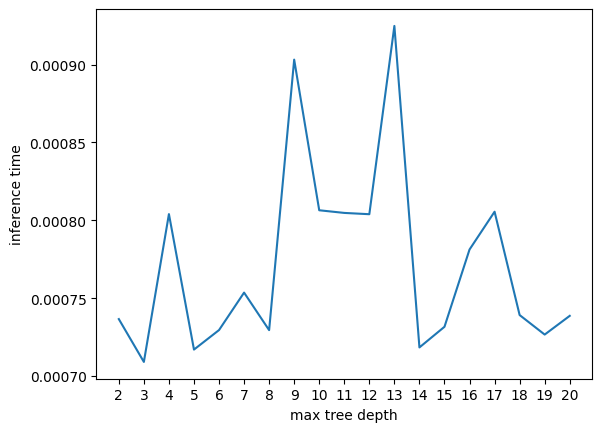

In [74]:
import timeit
depths = np.arange(2,21)
times = []


for d in depths:
    dtc_ = DecisionTreeClassifier(max_depth = d, random_state=136) # Train trees with different depths
    dtc_.fit(X_train, y_train)


    inference_time = timeit.timeit(lambda: dtc_.predict(X_test), number=500) / 500 # Time 500 predictions, then divide to get the average  

    times.append(inference_time)
    

    
plt.plot(depths, times)
plt.xticks(ticks=depths)
plt.xlabel("max tree depth")
plt.ylabel("inference time");